In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools
import constants

0.00014746639368170598 21.000000000000018
21.480000000000018


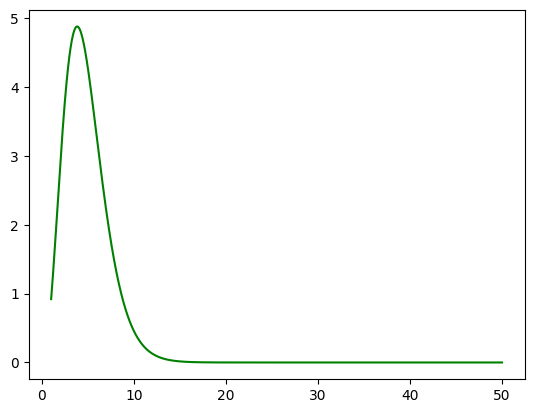

In [4]:
# test fonction intégrale

def fonction(x) :
    num = np.exp(x)*(x**4)
    denom = (np.exp(x) -1 )**2
    return num/denom

temp_test = np.arange(1, 50, 1e-2)

plt.figure()
plt.plot(temp_test, fonction(temp_test), "-g")

def zero(x, y, eps=1e-4) :
    i = 0
    for i in range(0, len(y)) :
        if y[i] < eps :
            return x[i]

print(fonction(temp_test)[2000], temp_test[2000])
print(zero(temp_test, fonction(temp_test)))

In [1]:
def fonction_debye(temperature, temp_debye) :
    alpha = 1/temperature
    return fonction(alpha*temp_debye)

    